## Import libraries

In [3]:
pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 9.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 49.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [26]:
import os
import random
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch

import tensorflow as tf
import tensorflow_datasets as tfds

from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import TrainingArguments, Trainer

import datasets
from datasets import load_metric

# Mounting Google Drive

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/MP

/content/drive/MyDrive/MP


In [7]:
!pwd

/content/drive/MyDrive/MP


## Define Functions

In [8]:
def show_img(data, class_names):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.asarray(data['image'][i]))
        plt.title(class_names[str(data['label'][i])])
        plt.axis("off")

In [9]:
# Defing a function print shape of dataset (loaded from keras dataset)
def dataset_shape(dataset):
    for image_batch, labels_batch in dataset:
        print('images: ', image_batch.shape)
        print('labels: ', labels_batch.shape)
        break

In [10]:
def data_files ():
    data_size = 0
    for dirname, _, filenames in os.walk('/content/drive/MyDrive/MP/Train'):
        for filename in filenames:
# print(os.path.join(dirname, filename))
            data_size += 1
    return data_size

In [28]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [11]:
def gen_encoding(batch):
    inputs = feature_extractor([x for x in batch['image']], return_tensors='pt')
    inputs['label'] = batch['label']

    return inputs

In [30]:
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

## Define Variables

In [12]:
# hyperparameter
DATA_DIR='/content/drive/MyDrive/MP/Train'
OUTPUT_DIR='./trainingOutput'
height=256
width=256
channels=3
batch_size=64
seed=42
img_shape=(height, width, channels)
img_size=(height, width)
model_id='google/vit-base-patch16-224'
metric=load_metric("accuracy")

<ipython-input-12-6da6506e2090>:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric=load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [13]:
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
# model = ViTForImageClassification.from_pretrained(model_id)

# print(feature_extractor)
# print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [14]:
DATASET_SIZE=data_files()

train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

print(DATASET_SIZE)
print(train_size)
print(val_size)
print(test_size)

832
665
83
83


## Preprocessing

In [15]:
# Load image (loaded from datasets)
dataset = datasets.load_dataset('imagefolder', data_dir='/content/drive/MyDrive/MP/Train')
ds = dataset['train']
ds = ds.shuffle(seed=seed)
ds['label'][:10]

Resolving data files:   0%|          | 0/832 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[0, 1, 0, 4, 1, 4, 0, 4, 2, 2]

In [16]:
# Split data (loaded from datasets)
train_dsX = ds['image'][0:train_size]
val_dsX = ds['image'][train_size:train_size+val_size]
test_dsX = ds['image'][train_size+val_size:DATASET_SIZE]

print('train_dsX: ', len(train_dsX), type(train_dsX))
print('val_dsX: ', len(val_dsX), type(val_dsX))
print('test_dsX: ', len(test_dsX), type(test_dsX))

train_dsY = ds['label'][0:train_size]
val_dsY = ds['label'][train_size:train_size+val_size]
test_dsY = ds['label'][train_size+val_size:DATASET_SIZE]

print('train_dsY: ', len(train_dsY), type(train_dsY))
print('val_dsY: ', len(val_dsY), type(val_dsY))
print('test_dsY: ', len(test_dsY), type(test_dsY))

train_ds = datasets.Dataset.from_dict({'image': train_dsX, 'label': train_dsY})
test_ds = datasets.Dataset.from_dict({'image': test_dsX, 'label': test_dsY})
val_ds = datasets.Dataset.from_dict({'image': val_dsX, 'label': val_dsY})

print('train_ds: ', train_ds)
print('test_ds: ', test_ds)
print('val_ds: ', val_ds)

train_dsX:  665 <class 'list'>
val_dsX:  83 <class 'list'>
test_dsX:  84 <class 'list'>
train_dsY:  665 <class 'list'>
val_dsY:  83 <class 'list'>
test_dsY:  84 <class 'list'>
train_ds:  Dataset({
    features: ['image', 'label'],
    num_rows: 665
})
test_ds:  Dataset({
    features: ['image', 'label'],
    num_rows: 84
})
val_ds:  Dataset({
    features: ['image', 'label'],
    num_rows: 83
})


In [17]:
class_names = ds.features["label"].names
id2label = {str(i): label for i, label in enumerate(class_names)}
label2id = {v: k for k, v in id2label.items()}

In [18]:
pt_train_ds = train_ds.with_transform(gen_encoding)
pt_val_ds = val_ds.with_transform(gen_encoding)
pt_test_ds = test_ds.with_transform(gen_encoding)

## View Dataset

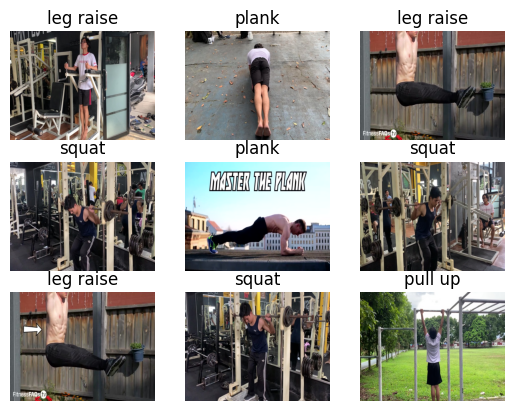

In [19]:
show_img(train_ds, id2label)

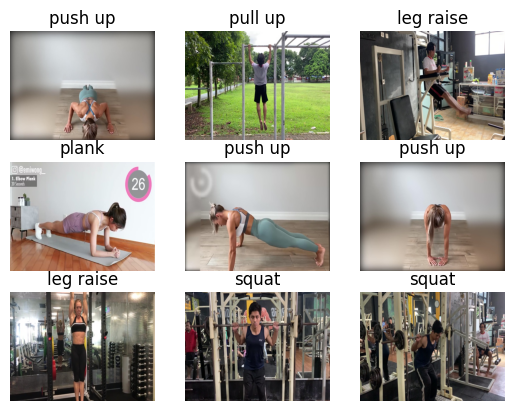

In [20]:
show_img(test_ds, id2label)

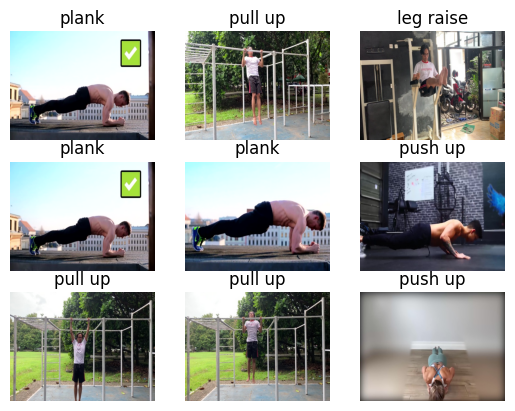

In [21]:
show_img(val_ds, id2label)

## Define Model

In [22]:
model = ViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(class_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args = TrainingArguments(
  output_dir=OUTPUT_DIR,
  per_device_train_batch_size=batch_size,
  evaluation_strategy="steps",
  num_train_epochs=8,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=pt_train_ds,
    eval_dataset=pt_val_ds,
    tokenizer=feature_extractor
)

## Train Model

In [32]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss


***** train metrics *****
  epoch                    =         8.0
  total_flos               = 383954932GF
  train_loss               =      0.0326
  train_runtime            =  0:03:30.04
  train_samples_per_second =      25.328
  train_steps_per_second   =       0.419


In [33]:
metrics = trainer.evaluate(pt_test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        8.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0001
  eval_runtime            = 0:00:01.62
  eval_samples_per_second =     51.604
  eval_steps_per_second   =      6.758


## Test fine tuned model

In [34]:
model_id='/content/drive/MyDrive/MP/trainingOutput'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
model = ViTForImageClassification.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


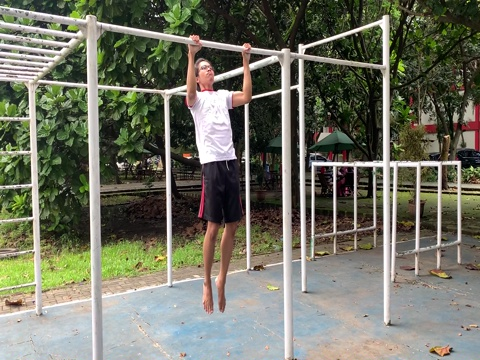

Predicted class: pull up


In [35]:
image = test_ds[random.randrange(len(test_ds))]['image']
display(image)

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

# Running

In [36]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

'NoneType' object has no attribute 'split'


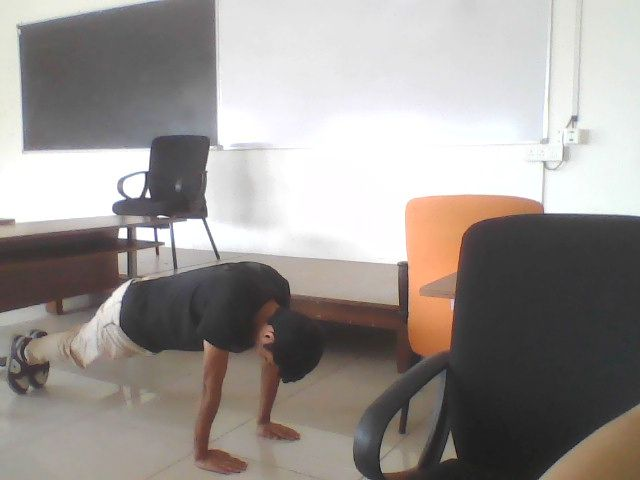

Predicted class: push up


In [ ]:
from PIL import Image

# Load the image using PIL
image = Image.open('photo.jpg')
display(image)
# Display the image if needed
# image.show()

# Now pass the image data to the feature_extractor
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])